# 🧩 Inference: Integrating the Trained Model into the Pipeline

The trained YOLO model is now used in our complete document-processing system:

- fast PDF → image conversion  
- QR detection (ZXing-C++)  
- YOLO-based signature & seal detection  
- PDF annotation (colored boxes, banners, clickable links)  
- JSON output per PDF  
- final merged JSON  

The following section demonstrates how the model is deployed for the full challenge solution.

In [10]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import fitz  # PyMuPDF
import cv2
import numpy as np
import zxingcpp
import json
import torch

from ultralytics import YOLO
from concurrent.futures import ThreadPoolExecutor, as_completed
from threading import Lock

# -----------------------
# CONFIG
# -----------------------
INPUT_DIR = r"D:\studying\university\armeta_hackathon\selected_output\pdfs"
OUTPUT_DIR = "annotated_pdfs"
JSON_DIR = "json"          
DPI = 300

YOLO_WEIGHTS_PATH = r"D:\studying\university\armeta_hackathon\runs\detect\train_final\weights\best.pt"

# Parallel workers (threads)
NUM_WORKERS = 4

# colors (R,G,B) in 0–1 range for PyMuPDF
COLOR_QR = (1, 0, 0)         # red
COLOR_SIGNATURE = (0, 0, 1)  # blue
COLOR_STAMP = (0, 0.4, 0)    # green
COLOR_OTHER = (1, 0, 0)      # default red

WHITE = (1, 1, 1)
LABEL_HEIGHT = 16            # height of top banner in PDF units

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# YOLO per-category settings (you can tune these)
SIG_IMGSZ = 1280
SIG_CONF  = 0.42
SIG_IOU   = 0.35
SIG_MAX_DET = 100

STAMP_IMGSZ = 1280
STAMP_CONF  = 0.25
STAMP_IOU   = 0.35
STAMP_MAX_DET = 100

# -----------------------
# AREA FILTERS (image-space)
# -----------------------
# These are in *image* pixels: area = width * height of bbox in the rendered image.
# Tune these values based on your real data.
signature_MIN_AREA = 1000       # ignore signatures smaller than this
signature_MAX_AREA = 4000000    # ignore signatures larger than this

STAMP_MIN_AREA = 1000           # ignore stamps smaller than this
STAMP_MAX_AREA = 1500000        # ignore stamps larger than this

# Global lock to serialize YOLO inference
YOLO_LOCK = Lock()


def normalize_category(cls_name: str):
    """Map YOLO class name to normalized category."""
    name = cls_name.lower()

    if any(s in name for s in ["signature", "sign"]):
        return "signature"
    if "seal" in name or "stamp" in name:
        return "stamp"
    return name  # fallback


def get_color_for_category(category: str):
    cat = category.lower()
    if cat == "qr":
        return COLOR_QR
    if cat == "signature":
        return COLOR_SIGNATURE
    if cat == "stamp":
        return COLOR_STAMP
    return COLOR_OTHER


def looks_like_url(text: str) -> bool:
    if not text:
        return False
    t = text.strip().lower()
    return t.startswith("http://") or t.startswith("https://")


def draw_box_with_label(page, rect, label_text, color):
    """
    Draws:
    - colored bbox (stroke)
    - colored banner at top of bbox
    - white label text inside banner
    """
    # bbox
    page.draw_rect(rect, color=color, width=1, overlay=True)

    # label banner
    x1, y1, x2, y2 = rect
    top = max(y1 - LABEL_HEIGHT, 0)  # avoid going above page
    label_rect = fitz.Rect(x1, top, x2, y1)

    # filled banner (same color as box)
    page.draw_rect(label_rect, color=color, fill=color, width=0, overlay=True)

    # text position: small left margin, near bottom of banner
    text_x = x1 + 2
    text_y = top + LABEL_HEIGHT - 2  # baseline a bit above bottom
    page.insert_text(
        fitz.Point(text_x, text_y),
        label_text,
        fontsize=14,
        color=WHITE,
        overlay=True,
    )


def get_class_ids_by_keywords(yolo_names, keywords):
    """
    Build a list of class IDs whose names contain any of the given keywords.
    Works whether yolo_names is a list or dict.
    """
    ids = []
    if isinstance(yolo_names, dict):
        items = yolo_names.items()
    else:
        items = enumerate(yolo_names)

    kw_lower = [k.lower() for k in keywords]

    for idx, name in items:
        n = str(name).lower()
        if any(k in n for k in kw_lower):
            ids.append(idx)
    return ids


def process_single_pdf(pdf_path, yolo_model, dpi=DPI):
    """
    Process one PDF: render each page once -> run QR + YOLO, draw boxes
    with colored top banners and labels, add QR links.

    Returns:
      pdf_name, {
        "page_1": { ... },
        "page_2": { ... },
        ...
      }
    """
    doc = fitz.open(pdf_path)
    pdf_name = os.path.basename(pdf_path)

    selected_annotations = {pdf_name: {}}
    annotation_id = 1  # local per-PDF

    # YOLO class names
    yolo_names = yolo_model.names if hasattr(yolo_model, "names") else {}

    # Discover which class IDs correspond to signatures and stamps/seals via name keywords
    signature_class_ids = get_class_ids_by_keywords(
        yolo_names,
        ["signature", "sign"]
    )
    stamp_class_ids = get_class_ids_by_keywords(
        yolo_names,
        ["seal", "stamp"]
    )

    print(f"[{pdf_name}] sig_ids={signature_class_ids}, stamp_ids={stamp_class_ids}")

    for page_index in range(len(doc)):
        page = doc[page_index]
        page_num = page_index + 1
        page_key = f"page_{page_num}"

        # ----- render page ONCE -----
        zoom = dpi / 72.0
        mat = fitz.Matrix(zoom, zoom)
        pix = page.get_pixmap(matrix=mat, alpha=False)
        img = np.frombuffer(pix.samples, dtype=np.uint8).reshape(
            pix.height, pix.width, pix.n
        )

        # convert to BGR (shared for both QR & YOLO)
        if pix.n == 4:
            img_bgr = cv2.cvtColor(img, cv2.COLOR_RGBA2BGR)
        elif pix.n == 3:
            img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        elif pix.n == 1:
            img_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        else:
            img_bgr = img

        page_width = pix.width
        page_height = pix.height

        page_entry = {
            "annotations": [],
            "page_size": {"width": page_width, "height": page_height},
        }

        # ===========================
        # 1) QR DETECTION (zxingcpp)
        # ===========================
        qr_results = zxingcpp.read_barcodes(img_bgr)

        for r in qr_results:
            # keep only QR codes
            if "QR" not in str(r.format):
                continue

            pos = r.position
            pts = [
                (pos.top_left.x, pos.top_left.y),
                (pos.top_right.x, pos.top_right.y),
                (pos.bottom_right.x, pos.bottom_right.y),
                (pos.bottom_left.x, pos.bottom_left.y),
            ]

            xs = [p[0] for p in pts]
            ys = [p[1] for p in pts]

            ix1, iy1 = float(min(xs)), float(min(ys))
            ix2, iy2 = float(max(xs)), float(max(ys))

            # image-space bbox for JSON
            x_img = ix1
            y_img = iy1
            w_img = ix2 - ix1
            h_img = iy2 - iy1
            area = w_img * h_img

            # PDF coords for drawing
            x1_pdf = ix1 / zoom
            y1_pdf = iy1 / zoom
            x2_pdf = ix2 / zoom
            y2_pdf = iy2 / zoom
            rect = fitz.Rect(x1_pdf, y1_pdf, x2_pdf, y2_pdf)

            category = "qr"
            color = get_color_for_category(category)

            # label text (name of annotation)
            label_text = "QR"

            # draw bbox + top banner + text
            draw_box_with_label(page, rect, label_text, color)

            # clickable link from QR content (if it looks like URL)
            qr_text = r.text
            if looks_like_url(qr_text):
                page.insert_link(
                    {
                        "kind": fitz.LINK_URI,
                        "from": rect,
                        "uri": qr_text,
                    }
                )

            ann_key = f"annotation_{annotation_id}"
            annotation_id += 1

            page_entry["annotations"].append(
                {
                    ann_key: {
                        "category": category,
                        "bbox": {
                            "x": x_img,
                            "y": y_img,
                            "width": w_img,
                            "height": h_img,
                        },
                        "area": area
                    }
                }
            )

        # ===========================
        # 2) YOLO DETECTION
        #    a) SIGNATURES (with area filters)
        #    b) STAMPS / SEALS (with area filters)
        # ===========================

        # ---------- (a) Signatures ----------
        if signature_class_ids:
            with YOLO_LOCK:
                sig_results = yolo_model(
                    img_bgr,
                    verbose=False,
                    imgsz=SIG_IMGSZ,
                    conf=SIG_CONF,
                    iou=SIG_IOU,
                    max_det=SIG_MAX_DET,
                    classes=signature_class_ids,
                )

            yres_sig = sig_results[0]
            if yres_sig.boxes is not None and len(yres_sig.boxes) > 0:
                xyxy = yres_sig.boxes.xyxy.cpu().numpy()  # shape (N,4)
                cls_ids = yres_sig.boxes.cls.cpu().numpy().astype(int)
                confs = yres_sig.boxes.conf.cpu().numpy()

                for (x1, y1, x2, y2), cls_id, conf in zip(xyxy, cls_ids, confs):
                    # image-space bbox
                    x_img = float(x1)
                    y_img = float(y1)
                    w_img = float(x2 - x1)
                    h_img = float(y2 - y1)
                    area = w_img * h_img

                    # SIGNATURE AREA FILTER
                    if area < signature_MIN_AREA or area > signature_MAX_AREA:
                        continue

                    # PDF coords for drawing
                    x1_pdf = x_img / zoom
                    y1_pdf = y_img / zoom
                    x2_pdf = (x_img + w_img) / zoom
                    y2_pdf = (y_img + h_img) / zoom
                    rect = fitz.Rect(x1_pdf, y1_pdf, x2_pdf, y2_pdf)

                    # convert YOLO class id -> category name
                    if isinstance(yolo_names, dict):
                        cls_name = yolo_names.get(cls_id, str(cls_id))
                    else:
                        cls_name = str(yolo_names[cls_id])
                    category = normalize_category(cls_name)
                    color = get_color_for_category(category)

                    # label text: name + confidence
                    label_text = f"{category} {conf:.2f}"

                    # draw bbox + top banner + text
                    draw_box_with_label(page, rect, label_text, color)

                    ann_key = f"annotation_{annotation_id}"
                    annotation_id += 1

                    page_entry["annotations"].append(
                        {
                            ann_key: {
                                "category": category,
                                "bbox": {
                                    "x": x_img,
                                    "y": y_img,
                                    "width": w_img,
                                    "height": h_img,
                                },
                                "area": area,
                                "confidence": float(conf),
                                "label": label_text,
                            }
                        }
                    )

        # ---------- (b) Stamps / Seals ----------
        if stamp_class_ids:
            with YOLO_LOCK:
                stamp_results = yolo_model(
                    img_bgr,
                    verbose=True,
                    imgsz=STAMP_IMGSZ,
                    conf=STAMP_CONF,
                    iou=STAMP_IOU,
                    max_det=STAMP_MAX_DET,
                    classes=stamp_class_ids,
                )

            yres_stamp = stamp_results[0]
            if yres_stamp.boxes is not None and len(yres_stamp.boxes) > 0:
                xyxy = yres_stamp.boxes.xyxy.cpu().numpy()  # shape (N,4)
                cls_ids = yres_stamp.boxes.cls.cpu().numpy().astype(int)
                confs = yres_stamp.boxes.conf.cpu().numpy()

                for (x1, y1, x2, y2), cls_id, conf in zip(xyxy, cls_ids, confs):
                    # image-space bbox
                    x_img = float(x1)
                    y_img = float(y1)
                    w_img = float(x2 - x1)
                    h_img = float(y2 - y1)
                    area = w_img * h_img

                    # convert YOLO class id -> category name (seal or stamp)
                    if isinstance(yolo_names, dict):
                        cls_name = yolo_names.get(cls_id, str(cls_id))
                    else:
                        cls_name = str(yolo_names[cls_id])
                    category = normalize_category(cls_name)

                    # AREA FILTERS for stamps/seals
                    if category == "stamp":
                        if area < STAMP_MIN_AREA or area > STAMP_MAX_AREA:
                            continue

                    # PDF coords for drawing
                    x1_pdf = x_img / zoom
                    y1_pdf = y_img / zoom
                    x2_pdf = (x_img + w_img) / zoom
                    y2_pdf = (y_img + h_img) / zoom
                    rect = fitz.Rect(x1_pdf, y1_pdf, x2_pdf, y2_pdf)

                    color = get_color_for_category(category)

                    # label text: name + confidence
                    label_text = f"{category} {conf:.2f}"

                    # draw bbox + top banner + text
                    draw_box_with_label(page, rect, label_text, color)

                    ann_key = f"annotation_{annotation_id}"
                    annotation_id += 1

                    page_entry["annotations"].append(
                        {
                            ann_key: {
                                "category": category,
                                "bbox": {
                                    "x": x_img,
                                    "y": y_img,
                                    "width": w_img,
                                    "height": h_img,
                                },
                                "area": area,
                                "confidence": float(conf),
                                "label": label_text,
                            }
                        }
                    )

        # store page info
        selected_annotations[pdf_name][page_key] = page_entry

    # save processed PDF
    output_pdf_path = os.path.join(OUTPUT_DIR, pdf_name)
    doc.save(output_pdf_path)
    doc.close()

    print(f"Finished {pdf_name}")

    return pdf_name, selected_annotations[pdf_name]


def main():
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    os.makedirs(JSON_DIR, exist_ok=True)

    # collect all PDFs
    pdf_paths = [
        os.path.join(INPUT_DIR, fname)
        for fname in os.listdir(INPUT_DIR)
        if fname.lower().endswith(".pdf")
    ]

    if not pdf_paths:
        print("No PDFs found in", INPUT_DIR)
        return

    print(f"Found {len(pdf_paths)} PDFs. Using device: {DEVICE}")
    print(f"Running with {NUM_WORKERS} worker threads...")

    # Load YOLO model once (GPU if available), shared across threads
    yolo_model = YOLO(YOLO_WEIGHTS_PATH)
    yolo_model.to(DEVICE)

    # open global JSON file for streaming (full annotations)
    combined_json_path = os.path.join(JSON_DIR, "selected_annotations.json")
    combined_f = open(combined_json_path, "w", encoding="utf-8")
    combined_f.write("{\n")
    first_pdf = True

    # Process PDFs in parallel with threads
    with ThreadPoolExecutor(max_workers=NUM_WORKERS) as executor:
        futures = {
            executor.submit(process_single_pdf, p, yolo_model, DPI): p
            for p in pdf_paths
        }

        for fut in as_completed(futures):
            pdf_path = futures[fut]
            try:
                pdf_name, pages_dict = fut.result()
            except Exception as e:
                print(f"Error processing {pdf_path}: {e}")
                continue

            # Write this PDF's annotations into combined JSON (main thread only)
            if not first_pdf:
                combined_f.write(",\n")
            else:
                first_pdf = False

            combined_f.write("  ")
            json.dump(pdf_name, combined_f, ensure_ascii=False)
            combined_f.write(": ")
            json.dump(pages_dict, combined_f, ensure_ascii=False, indent=2)

    combined_f.write("\n}\n")
    combined_f.close()

    print("\nAll PDFs processed.")
    print("Combined JSON:", combined_json_path)


if __name__ == "__main__":
    main()


Found 45 PDFs. Using device: cuda
Running with 4 worker threads...
[АПЗ-.pdf] sig_ids=[0], stamp_ids=[1]
[АПЗ-2.pdf] sig_ids=[0], stamp_ids=[1]
[АПЗ-31-.pdf] sig_ids=[0], stamp_ids=[1]
[АПЗ-41-чб.pdf] sig_ids=[0], stamp_ids=[1]

0: 1280x928 (no detections), 54.7ms
Speed: 8.8ms preprocess, 54.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 928)

0: 1280x928 (no detections), 54.2ms
Speed: 13.5ms preprocess, 54.2ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 928)

0: 1280x928 (no detections), 54.5ms
Speed: 13.4ms preprocess, 54.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 928)

0: 1280x928 (no detections), 112.8ms
Speed: 42.0ms preprocess, 112.8ms inference, 4.4ms postprocess per image at shape (1, 3, 1280, 928)

0: 1280x928 (no detections), 54.2ms
Speed: 13.8ms preprocess, 54.2ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 928)

0: 1280x928 (no detections), 59.9ms
Speed: 31.7ms preprocess, 59.9ms inference, 1.3ms post

In [7]:
import json
from collections import defaultdict

# -------------------------
# CONFIG
# -------------------------
GT_JSON_PATH = r"D:\studying\university\armeta_hackathon\selected_output\selected_annotations.json"                # ground truth JSON
PRED_JSON_PATH = r"D:\studying\university\armeta_hackathon\json\selected_annotations.json"   # predictions JSON

CATEGORIES = {"qr", "stamp", "signature"}


# -------------------------
# HELPERS
# -------------------------
def normalize_cat(cat: str) -> str:
    if not cat:
        return ""
    name = cat.lower()
    if "sign" in name or "signature" in name:
        return "signature"
    if "seal" in name or "stamp" in name:
        return "stamp"
    if "qr" in name:
        return "qr"
    return name


def load_json(path):
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)


def count_categories_on_page(page_data):
    """
    page_data:
    {
      "annotations": [
        { "annotation_1": { "category": "...", ... } },
        ...
      ],
      "page_size": {...}
    }
    """
    counts = defaultdict(int)
    if not page_data:
        return counts

    for ann_entry in page_data.get("annotations", []):
        for _, ann_val in ann_entry.items():
            cat = normalize_cat(ann_val.get("category", ""))
            if cat in CATEGORIES:
                counts[cat] += 1
    return counts


# -------------------------
# MAIN
# -------------------------
def main():
    gt = load_json(GT_JSON_PATH)
    pred = load_json(PRED_JSON_PATH)

    pdf_names = sorted(set(gt.keys()) | set(pred.keys()))

    # per-category global stats
    gt_total = {c: 0 for c in CATEGORIES}
    pred_total = {c: 0 for c in CATEGORIES}
    abs_diff_sum = {c: 0 for c in CATEGORIES}  # sum over pages of |gt - pred|

    for pdf_name in pdf_names:
        gt_pages = gt.get(pdf_name, {})
        pred_pages = pred.get(pdf_name, {})

        page_keys = sorted(set(gt_pages.keys()) | set(pred_pages.keys()))

        for page_key in page_keys:
            gt_page = gt_pages.get(page_key, {})
            pred_page = pred_pages.get(page_key, {})

            gt_counts_page = count_categories_on_page(gt_page)
            pred_counts_page = count_categories_on_page(pred_page)

            for cat in CATEGORIES:
                g = gt_counts_page.get(cat, 0)
                p = pred_counts_page.get(cat, 0)

                gt_total[cat] += g
                pred_total[cat] += p
                abs_diff_sum[cat] += abs(g - p)

    # ---- print per-category results ----
    print("=== COUNT ACCURACY BY CATEGORY ===\n")
    overall_gt = 0
    overall_abs_diff = 0
    overall_pred = 0

    for cat in sorted(CATEGORIES):
        g = gt_total[cat]
        p = pred_total[cat]
        d = abs_diff_sum[cat]

        overall_gt += g
        overall_pred += p
        overall_abs_diff += d

        if g > 0:
            count_acc = max(0.0, 1.0 - d / g) * 100.0
        else:
            count_acc = None

        print(f"Category: {cat}")
        print(f"  GT total count:      {g}")
        print(f"  Pred total count:    {p}")
        print(f"  Sum |GT - Pred|:     {d}")
        if count_acc is not None:
            print(f"  Count accuracy:      {count_acc:.2f}%  (1 - sum|Δ| / GT)")
        else:
            print("  Count accuracy:      N/A (no GT objects)")
        print()

    # ---- overall (all categories) ----
    print("=== OVERALL (ALL CATEGORIES) ===")
    if overall_gt > 0:
        overall_acc = max(0.0, 1.0 - overall_abs_diff / overall_gt) * 100.0
    else:
        overall_acc = None

    print(f"  GT total count:      {overall_gt}")
    print(f"  Pred total count:    {overall_pred}")
    print(f"  Sum |GT - Pred|:     {overall_abs_diff}")
    if overall_acc is not None:
        print(f"  Overall count accuracy: {overall_acc:.2f}%")
    else:
        print("  Overall count accuracy: N/A (no GT objects)")


if __name__ == "__main__":
    main()
    print('\n METRICS ARE NOT CORRECT BECAUSE GROUND TRUTH LABELS WERE WRONG IN SOME PLACES')


=== COUNT ACCURACY BY CATEGORY ===

Category: qr
  GT total count:      95
  Pred total count:    95
  Sum |GT - Pred|:     34
  Count accuracy:      64.21%  (1 - sum|Δ| / GT)

Category: signature
  GT total count:      103
  Pred total count:    97
  Sum |GT - Pred|:     12
  Count accuracy:      88.35%  (1 - sum|Δ| / GT)

Category: stamp
  GT total count:      60
  Pred total count:    60
  Sum |GT - Pred|:     2
  Count accuracy:      96.67%  (1 - sum|Δ| / GT)

=== OVERALL (ALL CATEGORIES) ===
  GT total count:      258
  Pred total count:    252
  Sum |GT - Pred|:     48
  Overall count accuracy: 81.40%

 METRICS ARE NOT CORRECT BECAUSE GROUND TRUTH LABELS WERE WRONG IN SOME PLACES


#  METRICS ARE NOT CORRECT BECAUSE GROUND TRUTH LABELS WERE WRONG IN SOME PLACES
(files АПЗ-41-чб.pdf, чертеж-.pdf)

# example

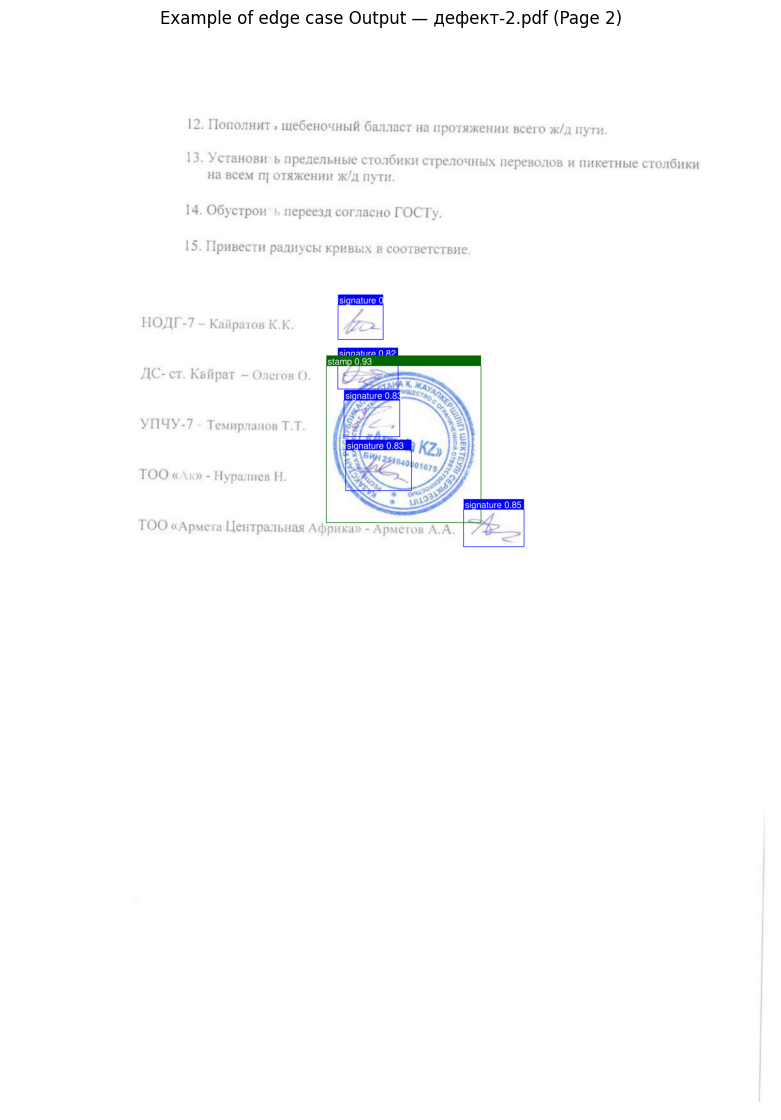

In [11]:
import fitz
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

example_pdf = r"D:\studying\university\armeta_hackathon\annotated_pdfs\дефект-2.pdf"
page_number = 1  

doc = fitz.open(example_pdf)
page = doc.load_page(page_number)
pix = page.get_pixmap(matrix=fitz.Matrix(2, 2))  # higher resolution

# Convert Pixmap → NumPy → PIL
img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

plt.figure(figsize=(10, 14))
plt.imshow(img)
plt.axis("off")
plt.title("Example of edge case Output — дефект-2.pdf (Page 2)")
plt.show()

doc.close()
